Author: [Ahmed Yousri Sobhi](ahmedyousrisobhi@gmail.com)

Created_at: 4th Sep 2023

Notebook number: 1

Objective: Raw data explorating analysis.

Abstract:
- Just before jumping into data cleaning and preprocessing, it's recommended to get familiar with our dataset first, and get a gentle introduction with it.
- Exploring each feature individually (uni-varient) will help us determine the preprocessing step required for that feature.

# Importing Required Libararies and Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# To display all the columns
pd.set_option('display.max_columns', None)

sns.set()
sns.set_style('whitegrid')

# dataprep for data report exploration
from dataprep.eda import create_report

# Required Functions

In [2]:
def plot_data_frequency(_df: pd.DataFrame, target_col: str, top_index=20, save_plot=True) -> None:
    """
        Used to plot bar plot of top n values in selected target col.
        
        PARAMETERS
            _df: pandas DataFrame, input dataset.
            target_col: str, input target col to plot its unique values count.
            top_index: int, top n index value to plot in the plotting.
            save_plot: boolean, determine whether to save the plot of not.
        
        RETURN
            None
    """
    
    # Setup the figure size
    plt.figure(figsize=(8, 6))

    percentage_counts = (
        _df[target_col]
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .rename(columns={'index':target_col})
        .sort_values('percentage', ascending=False)
        .iloc[:top_index]
    )

    # seaborn barplot
    sns.barplot(data=percentage_counts, x='percentage', y=target_col)

    # Rotate the x-axis labels
    plt.yticks(rotation=0)

    # Set the titel of the plot.
    plt.title(f'What is the most common used {target_col}?')

    # Save the plot
    if save_plot == True:
        try:
            plt.savefig(f'../report/plots/{target_col}_countplot.jpg', bbox_inches = 'tight')
        except FileNotFoundError:
            print('Wring file or file path')
            print('Creating new directory')
            # Create required directories
            if not os.path.exists('../report/plots'):
                os.makedirs('../report/plots/')
            plt.savefig(f'../report/plots/{target_col}_countplot.jpg', bbox_inches = 'tight')

    # Show the plot
    plt.show()


def plot_numeric_features(df:pd.DataFrame, cols_to_drop:list, plot_type, save_plot:bool) -> None:
    """
        Used to plot numerical featuers based on input selected plot.

        PARAMETERS
            df: pandas DataFrame, input dataframe.
            cols_to_drop: list, list of columns to drop.
            plot_type: function, define the plot type.
            save_plot: boolean, to whether save plot or not.
        
        RETURN
            None
    """

    # Select Numerical columns only
    features_numeric = (
        df.drop(cols_to_drop, axis=1)
        .select_dtypes('number')
        .columns.tolist()
    )

    # Calculate the number of rows and columns for subplots
    num_rows = int(len(features_numeric) / 2) + len(features_numeric) % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8+num_rows*2 + 1))

    # Iterate over features and plot distplot on subplots
    for i, feature in enumerate(features_numeric):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        plot_type(df[feature], ax=ax)
        ax.set_title(f'{plot_type.__name__} of {feature.capitalize()}')

    # Remove empty subplots if necessary
    if len(features_numeric) % 2 != 0:
        fig.delaxes(axes[num_rows - 1, num_cols - 1])

    # Set title for the whole plot
    fig.suptitle(f'{plot_type.__name__} Analysis', fontsize=16)
    plt.tight_layout()

    # Save the plot
    if save_plot == True:
        try:
            plt.savefig(f'../report/plots/numerical_{plot_type.__name__}.jpg',bbox_inches = 'tight')
        except FileNotFoundError:
            print('Wring file or file path')
            print('Creating new directory')
            # Create required directories
            if not os.path.exists('../report/plots'):
                os.makedirs('../report/plots/')
            plt.savefig(f'../report/plots/numerical_{plot_type.__name__}.jpg',bbox_inches = 'tight')
        
    plt.show()

def plot_timeseries_trend(df:pd.DataFrame, timestamp_col:str, target_col:str, groupby_lst:list=None, fig_title:str='', save:bool=False)->None:
    """
        Plot price trend per input selected feature

        Input:
            df: pandas DataFrame, input dataset.
            timestamp_col: str, timestamp feature which will be x-axis.
            target_col: str, target featuers, which will be y-axis
            groupby_col: list, features which the dataset will be grouped by.
            fig_title: str, title of the plot
            save: boolean, indicate whether save or not to save the plot.

        Output:
            None.
    """
    # Create a copy of input dataframe
    _df = df.copy()

    if groupby_lst is not None:

        # Group the data by category
        grouped_data = _df.sort_values(timestamp_col, ascending=True).groupby(groupby_lst)

        # Determine the number of categories
        num_categories = len(grouped_data)

        # Calculate the number of rows and columns for subplots
        num_rows = int(num_categories / 2) + num_categories % 2
        num_cols = 2

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

        # Flatten the axes array to easily iterate through subplots
        axes = axes.flatten()

        # Plotting the trend for each category
        for i, (category, group) in enumerate(grouped_data):
            ax = axes[i]  # Select the appropriate subplot
            ax.plot(group[timestamp_col], group[target_col])
            ax.set_title(category)
            ax.set_xlabel('Time')
            ax.set_ylabel(target_col)

        # Hide empty subplots if necessary
        if num_categories < num_rows * num_cols:
            for j in range(num_categories, num_rows * num_cols):
                fig.delaxes(axes[j])
    
    else:
        # Set the figure size
        plt.figure(figsize=(15, 10))

        # Create a time series plot
        sns.lineplot(x=timestamp_col, y=target_col, data=_df)

    plt.suptitle(fig_title)
    plt.tight_layout()  # Adjust the spacing between subplots
    
    if save==True:
        plt.savefig(f'../report/plots/{fig_title.replace(" ", "_")}.jpg')
    
    plt.show()

    return None

# Loading Dataset

In [3]:
# loading csv file
df = (
    pd.read_csv('../data/raw/marketing_campaign.csv', sep='\t')
    .assign(
        Dt_Customer= lambda x:pd.to_datetime(x.Dt_Customer, format='%d-%m-%Y')
    )
)
# display head of the dataset
display(df.head(5))

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [4]:
# display dataframe into
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

In [5]:
# Creating an analysis report regarding the dataset
report = create_report(df)
# Store the report in html format
try:
    report.save('../report/reports/raw_data_report')
except FileNotFoundError:
    print('Wring file or file path')
    print('Creating new directory')
    # Create required directories
    if not os.path.exists('../report/reports'):
        os.makedirs('../report/reports/')
    report.save('../report/reports/raw_data_report')

  0%|          | 0/4277 [00:00<?, ?it/s]

Report has been saved to ../report/reports/raw_data_report.html!


Some insights based on the report:
- Tiny percent of missing cells in the dataset, all located in feature 'Income'.
- There are no duplicated rows.
- Data types included are [Numerical:15, Categorical:13, DateTime:1].
- Features [MntFruits, MntSweetProducts] have similar distribution.
- Many features are skewed.
- Features like [MntFruits, MntFishProducts, MntSweetProducts, NumCatalogPurchases] have high percentage of zeros.

# Statistical Analysis

In [6]:
df.describe().T

count          mean           std     min       25%  \
ID                   2240.0   5592.159821   3246.662198     0.0   2828.25   
Year_Birth           2240.0   1968.805804     11.984069  1893.0   1959.00   
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
Kidhome              2240.0      0.444196      0.538398     0.0      0.00   
Teenhome             2240.0      0.506250      0.544538     0.0      0.00   
Recency              2240.0     49.109375     28.962453     0.0     24.00   
MntWines             2240.0    303.935714    336.597393     0.0     23.75   
MntFruits            2240.0     26.302232     39.773434     0.0      1.00   
MntMeatProducts      2240.0    166.950000    225.715373     0.0     16.00   
MntFishProducts      2240.0     37.525446     54.628979     0.0      3.00   
MntSweetProducts     2240.0     27.062946     41.280498     0.0      1.00   
MntGoldProds         2240.0     44.021875     52.167439     0.0      9.00   
NumDealsPurchases    2240.0      2.325000      1.932238     0.0      1.00   
NumWebPurchases      2240.0      4.084821      2.778714     0.0      2.00   
NumCatalogPurchases  2240.0      2.662054      2.923101     0.0      0.00   
NumStorePurchases    2240.0      5.790179      3.250958     0.0      3.00   
NumWebVisitsMonth    2240.0      5.316518      2.426645     0.0      3.00   
AcceptedCmp3         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp4         2240.0      0.074554      0.262728     0.0      0.00   
AcceptedCmp5         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp1         2240.0      0.064286      0.245316     0.0      0.00   
AcceptedCmp2         2240.0      0.013393      0.114976     0.0      0.00   
Complain             2240.0      0.009375      0.096391     0.0      0.00   
Z_CostContact        2240.0      3.000000      0.000000     3.0      3.00   
Z_Revenue            2240.0     11.000000      0.000000    11.0     11.00   
Response             2240.0      0.149107      0.356274     0.0      0.00   

                         50%       75%       max  
ID                    5458.5   8427.75   11191.0  
Year_Birth            1970.0   1977.00    1996.0  
Income               51381.5  68522.00  666666.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
MntWines               173.5    504.25    1493.0  
MntFruits                8.0     33.00     199.0  
MntMeatProducts         67.0    232.00    1725.0  
MntFishProducts         12.0     50.00     259.0  
MntSweetProducts         8.0     33.00     263.0  
MntGoldProds            24.0     56.00     362.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Z_CostContact            3.0      3.00       3.0  
Z_Revenue               11.0     11.00      11.0  
Response                 0.0      0.00       1.0

Insights:
- Outliers in feature 'Year_Birth', as the mean is around the [25th : Max] quantiles.
- Most of features [AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Complain, Response] have more than 75% are zeros.
- Constant value in feature 'Z_CostContact'.

# Uni-Varient Analysis
## Numerical Features

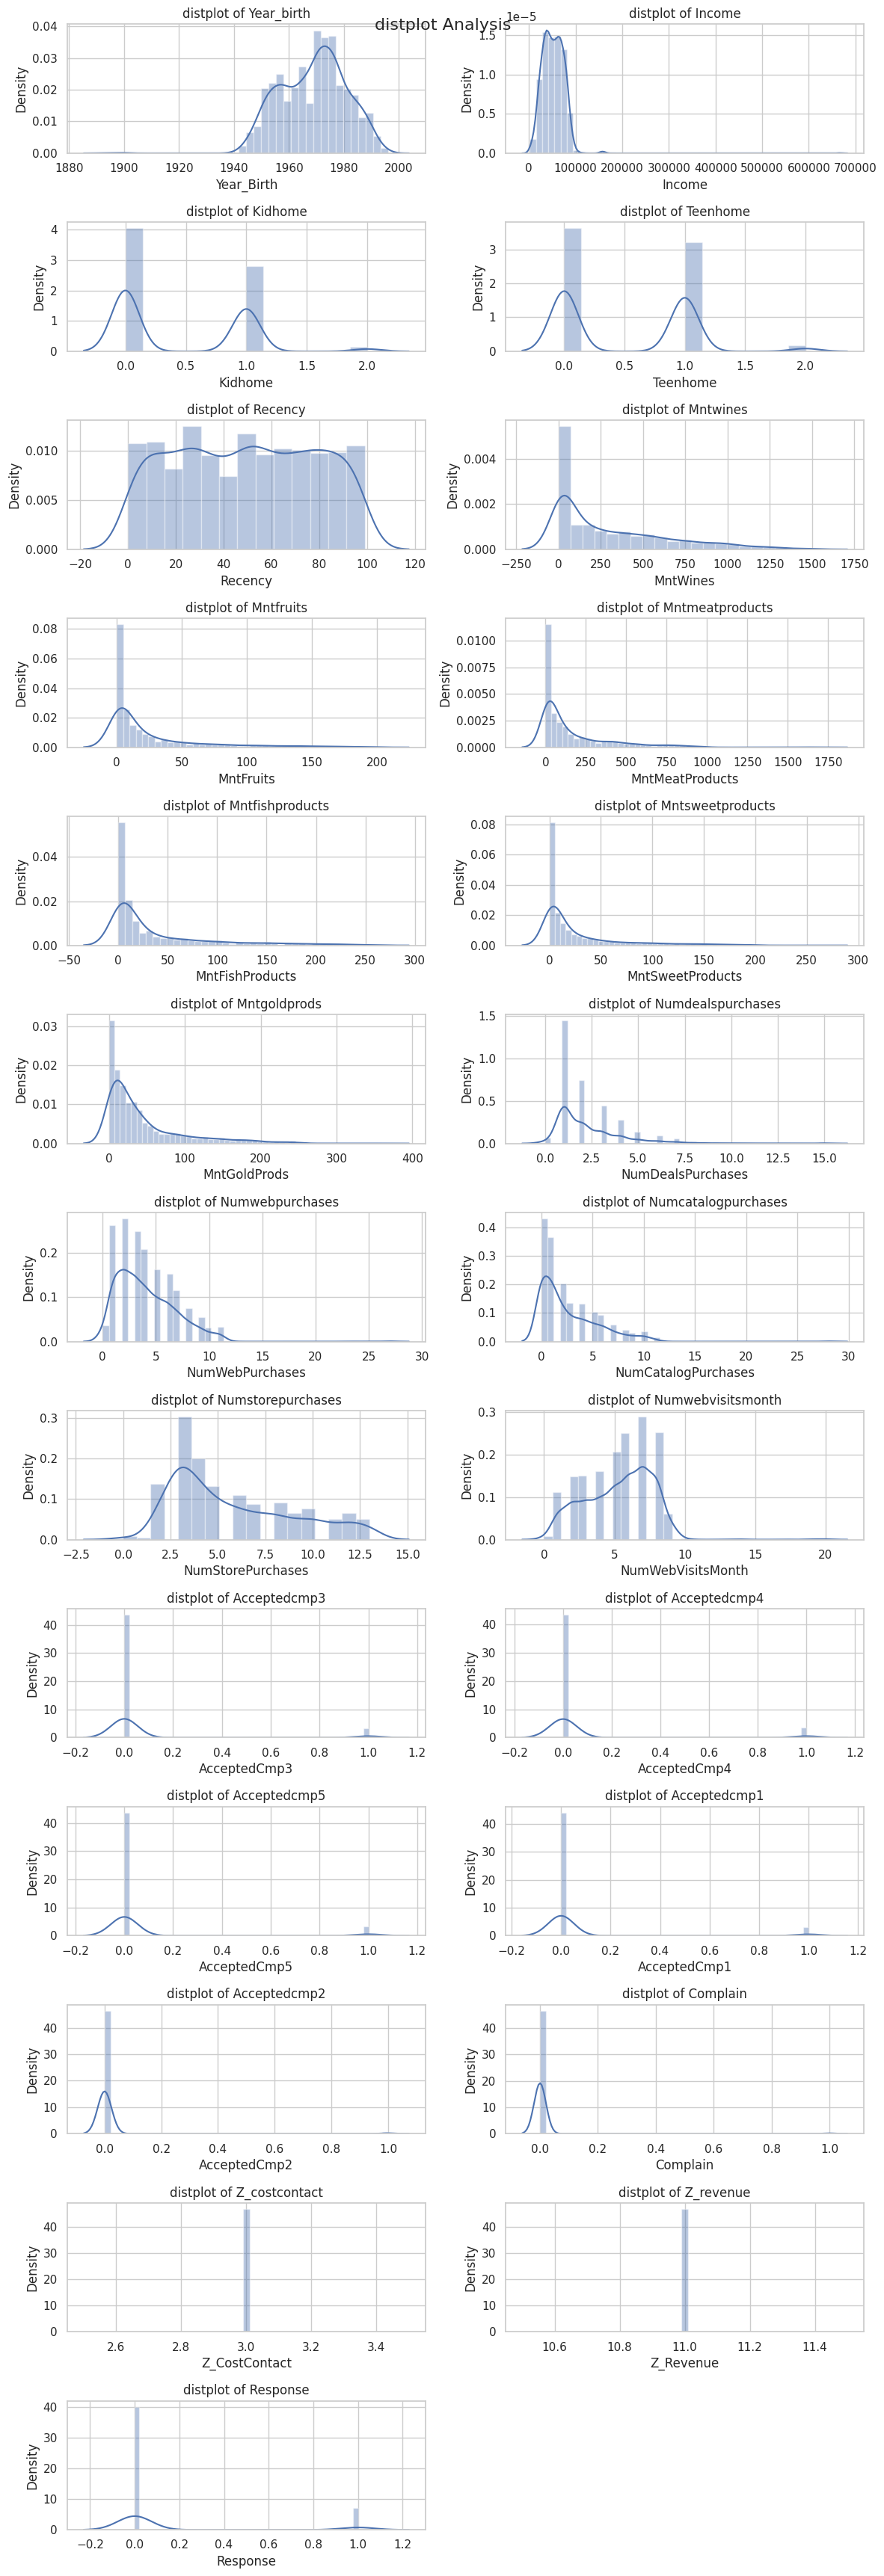

In [7]:
# Used to look at the distribution of a numerical variables
cols_to_drop = ['ID']
plot_numeric_features(df, cols_to_drop, sns.distplot, save_plot=True)

Exploring the distribution plots of each features, we concolude the following insights:
|Feature|Insights|
|--|--|
|Year_Birth| Most of the data distribution is located between years 1940 till 2000, and there are some outliers in the data should be removed.
|Income| Right skewed feature, owing the fact that there are high values of income which require invistigating to consider it outliers.
|Recency| represent uniform distribution
|Mntwines, Mntfruits, Mntmeatproduct, Mntfishproducts, mntsweetproducts, Mntgoldprods| These features have same right skewed distribution, which high percentage of zeros value.
|Numberwebvisitsmonth| Most of the distribution between [0 to 10] visits per month, but there are extreme values require investigating.
|Acceptedcmp Features| all 5 features has a similar distribution, they are consisting of two values of zeros and ones, and the majority is zeros which leads to imbalanced features.
|Z_costcontact|Constant value of 3$ which represent a uniform value in the all dataset. Since this column has no variability, it doesn't provide any distinguishing information within the dataset.
|Z_revenue| Constant value of 11$ which is similiar to the previous features in the insight.
|Response|The majority of the data are zeros, but still there are a small percentage of ones. 

To conclude:
- Some features require some investegating to be confident that there are outliers to be removed.
- Majority of customers do not buy most of the products, since majority of values are zeros in features related to products bought by customers.
- Value of cost and revenue do not have huge impact in our objective of customer clustering, for the reason that they have constant values.

### Handling Duplicated

In [8]:
# Check the Id column to be unique
df[df.duplicated(subset='ID')]

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

In [9]:
# Check any duplicated rows
df[df.duplicated()]

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

The Dataset does not have any duplicated id not rows.

### Checking if there are negative values

In [10]:
# Which columns contains negative values?
(df.select_dtypes('number')<0).any()

ID                     False
Year_Birth             False
Income                 False
Kidhome                False
Teenhome               False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool

There are any negative values in numerical features in the dataset.

### Checking missing values

In [11]:
df.isna().sum()*100/df.shape[0]

ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 1.071429
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
dtype: float64

There are small percentage of missing values in 'Income' feature.

Available options to handle these missing values:
- Remove the records which contains missing values, as they represent a small percentage in the dataset.
- Fill missing values by statistical Methods like [mean, mode].
- Regression imputation for these values depending on available features.

Deciding which method to use, depends on the other features, to make sure if we decide to drop these records, it will not affect certain category and lower its records percentage.

In [12]:
# Calculate percentage for each Education, Year_Birth, Marital_Status
df_subset = df[df.Income.isna()]

for feature in ['Education', 'Year_Birth', 'Marital_Status']:
    print("Percentage of lost records in feature:",feature)
    display(pd.DataFrame(df_subset[feature].value_counts()*100/df[feature].value_counts()))

Percentage of lost records in feature: Education


Education
2n Cycle     1.477833
Basic             NaN
Graduation   0.976043
Master       1.351351
PhD          1.028807

Percentage of lost records in feature: Year_Birth


Year_Birth
1893         NaN
1899         NaN
1900         NaN
1940         NaN
1941         NaN
1943   14.285714
1944         NaN
1945         NaN
1946         NaN
1947         NaN
1948         NaN
1949         NaN
1950         NaN
1951    2.325581
1952         NaN
1953         NaN
1954    2.000000
1955    2.040816
1956         NaN
1957    4.651163
1958    1.886792
1959    1.960784
1960         NaN
1961    2.777778
1962         NaN
1963    2.222222
1964    2.380952
1965         NaN
1966         NaN
1967         NaN
1968         NaN
1969    1.408451
1970    2.597403
1971    1.149425
1972    1.265823
1973    2.702703
1974         NaN
1975         NaN
1976         NaN
1977         NaN
1978    1.298701
1979         NaN
1980         NaN
1981    2.564103
1982    2.222222
1983    2.380952
1984         NaN
1985         NaN
1986    2.380952
1987         NaN
1988         NaN
1989    3.333333
1990         NaN
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN

Percentage of lost records in feature: Marital_Status


Marital_Status
Absurd               NaN
Alone                NaN
Divorced             NaN
Married         0.810185
Single          1.875000
Together        1.206897
Widow           1.298701
YOLO                 NaN

All the records per each features are small percentage, which indicate that we can simply remove the records containing missing values.

### Checking Outliers

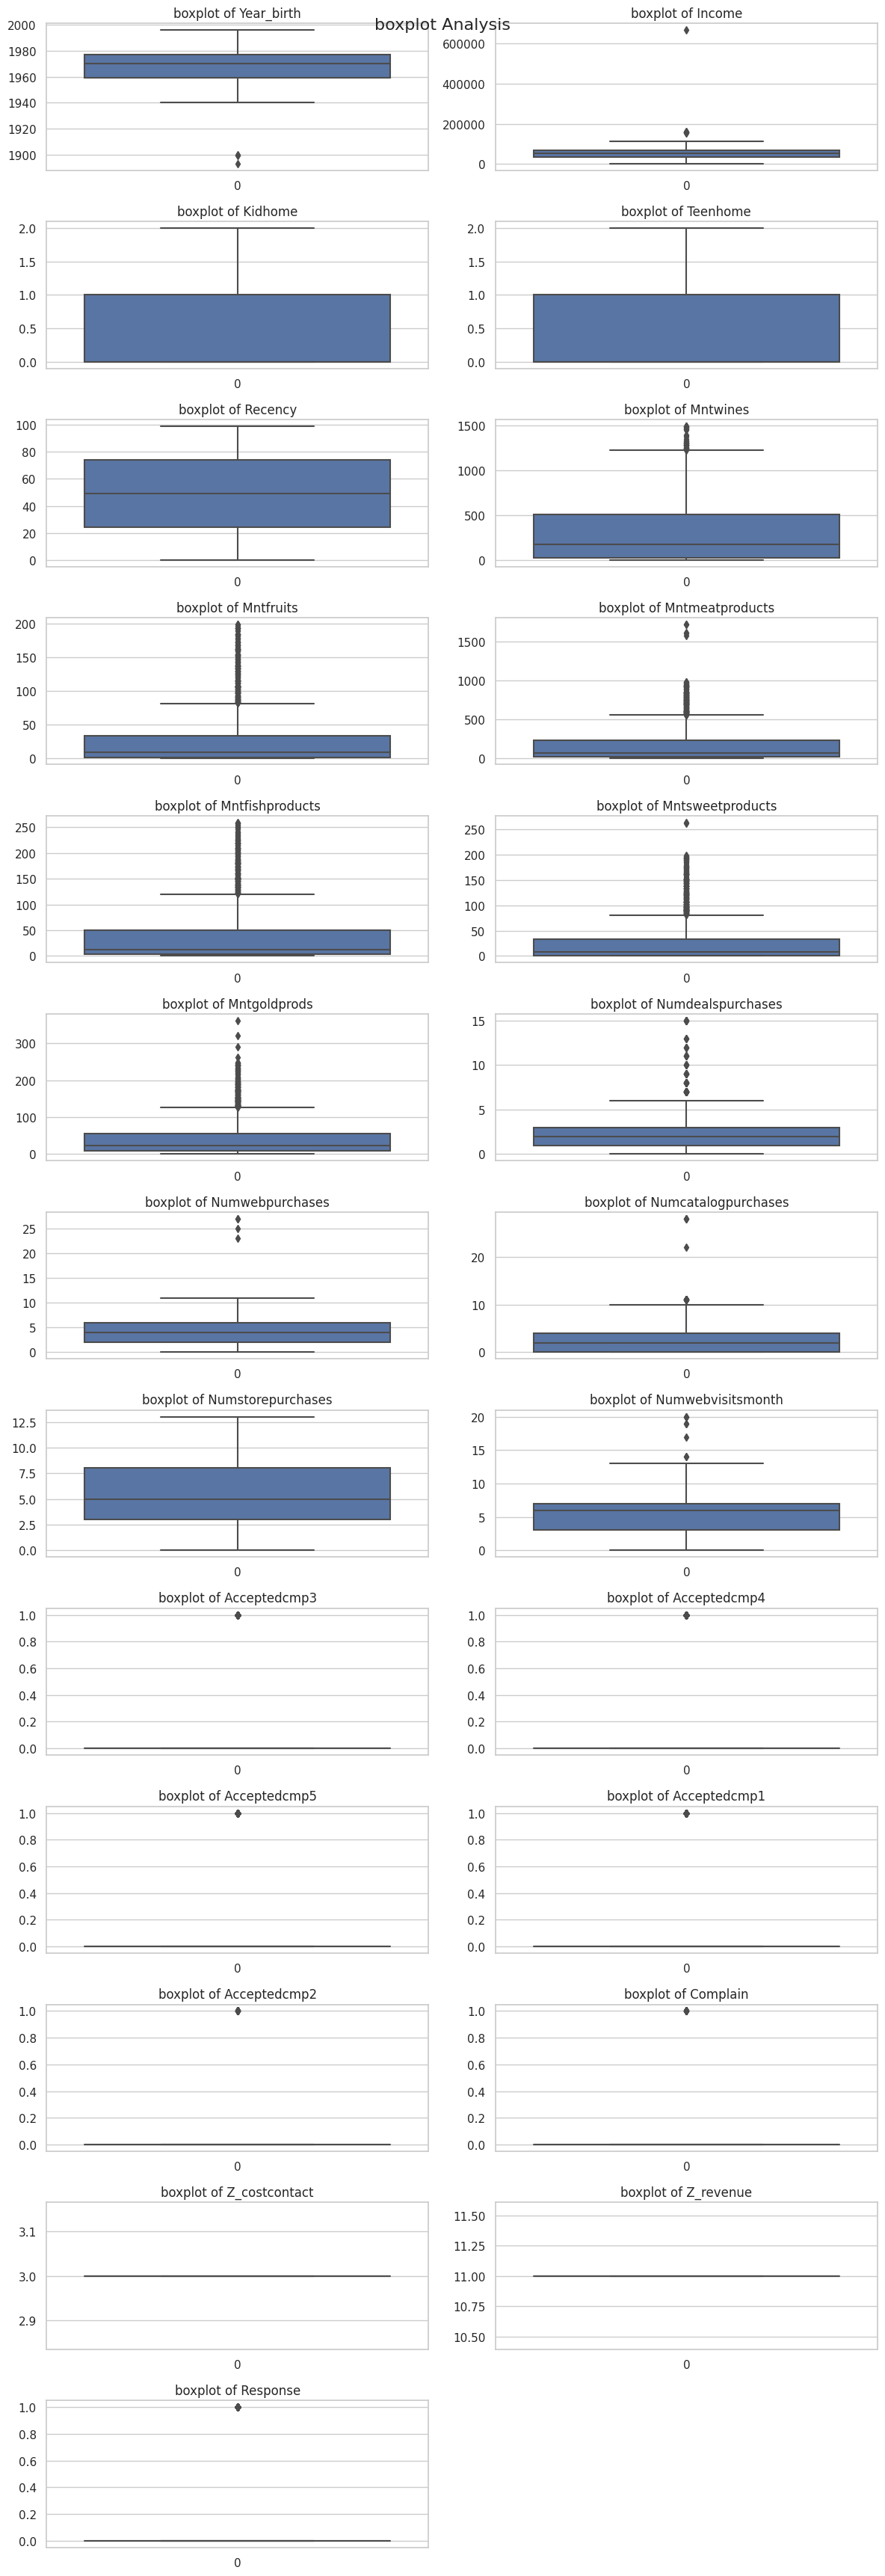

In [13]:
# Used to look at the distribution of a numerical variables
cols_to_drop = ['ID']
plot_numeric_features(df, cols_to_drop, sns.boxplot, save_plot=True)

There are possible outliers in featuers: [Income, Mntwines, Mntfishprods, Mntsweetprods, Mntgoldprods, Numwebpurchases, Numcatelogpurchases, Numwebvisitsmonth]

As we are interested in customer segmenation, we should first see the percentage of the records that considered as outliers before jumping to remove it.

In [14]:
# Count the percentage of records that considered as outliers in the following features
outliers_cols= [
    'Income',
    'MntWines', 
    'MntFishProducts', 
    'MntSweetProducts', 
    'MntGoldProds', 
    "NumDealsPurchases", 
    "NumCatalogPurchases", 
    "NumWebVisitsMonth"
    ]

df[outliers_cols].describe().T

count          mean           std     min       25%  \
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
MntWines             2240.0    303.935714    336.597393     0.0     23.75   
MntFishProducts      2240.0     37.525446     54.628979     0.0      3.00   
MntSweetProducts     2240.0     27.062946     41.280498     0.0      1.00   
MntGoldProds         2240.0     44.021875     52.167439     0.0      9.00   
NumDealsPurchases    2240.0      2.325000      1.932238     0.0      1.00   
NumCatalogPurchases  2240.0      2.662054      2.923101     0.0      0.00   
NumWebVisitsMonth    2240.0      5.316518      2.426645     0.0      3.00   

                         50%       75%       max  
Income               51381.5  68522.00  666666.0  
MntWines               173.5    504.25    1493.0  
MntFishProducts         12.0     50.00     259.0  
MntSweetProducts         8.0     33.00     263.0  
MntGoldProds            24.0     56.00     362.0  
NumDealsPurchases        2.0      3.00      15.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumWebVisitsMonth        6.0      7.00      20.0

In [15]:
# Calculate the records percentage of the outliers data in each feature
iqr = df[outliers_cols].quantile(0.75) - df[outliers_cols].quantile(0.25)
higher = df[outliers_cols].quantile(0.75) + iqr * 1.5

print("Percentage of outliers records:")
df_dict = {}
for col in outliers_cols:
    df_dict[col] = 100*df[df[col]> higher[col]].shape[0]/df.shape[0]

# Convert to dataframe
df_outlier_percentage = pd.DataFrame(df_dict.items() , columns=['feature', 'percentage'])

display(df_outlier_percentage)

Percentage of outliers records:


feature  percentage
0               Income    0.357143
1             MntWines    1.562500
2      MntFishProducts    9.955357
3     MntSweetProducts   11.071429
4         MntGoldProds    9.241071
5    NumDealsPurchases    3.839286
6  NumCatalogPurchases    1.026786
7    NumWebVisitsMonth    0.357143

In [16]:
# Setting threshold of 3%
outlier_thr = 3

outliers_cols_selected = (
    df_outlier_percentage[df_outlier_percentage.percentage <= outlier_thr]
    ['feature'].tolist()
)

outliers_cols_selected

['Income', 'MntWines', 'NumCatalogPurchases', 'NumWebVisitsMonth']

According to this percentage, we can drop outliers in the following features: [Income, MntWines, NumCatalogPurchases, NumWebVisitsMonth]

### How many unique valeus in each numeric feature?

In [17]:
df.select_dtypes('number').nunique()

ID                     2240
Year_Birth               59
Income                 1974
Kidhome                   3
Teenhome                  3
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

### Calculate the frequency for each unique value of each feature

In [18]:
numeric_cols = df.select_dtypes('number').columns.tolist()

# Drop ID columns
numeric_cols = list(set(numeric_cols) - set(['ID', 'Year_Birth']))

for col in numeric_cols:
    display(
        pd.DataFrame(df[col].value_counts(normalize=True).reset_index())
        .rename(columns = {
            'index':col,
            col:'Percentage'
        })
    )

AcceptedCmp4  Percentage
0             0    0.925446
1             1    0.074554

AcceptedCmp5  Percentage
0             0    0.927232
1             1    0.072768

NumWebPurchases  Percentage
0                 2    0.166518
1                 1    0.158036
2                 3    0.150000
3                 4    0.125000
4                 5    0.098214
5                 6    0.091518
6                 7    0.069196
7                 8    0.045536
8                 9    0.033482
9                 0    0.021875
10               11    0.019643
11               10    0.019196
12               27    0.000893
13               23    0.000446
14               25    0.000446

Kidhome  Percentage
0        0    0.577232
1        1    0.401339
2        2    0.021429

MntSweetProducts  Percentage
0                   0    0.187054
1                   1    0.071875
2                   2    0.057143
3                   3    0.045089
4                   4    0.036607
..                ...         ...
172               146    0.000446
173               132    0.000446
174               167    0.000446
175                99    0.000446
176               111    0.000446

[177 rows x 2 columns]

NumDealsPurchases  Percentage
0                   1    0.433036
1                   2    0.221875
2                   3    0.132589
3                   4    0.084375
4                   5    0.041964
5                   6    0.027232
6                   0    0.020536
7                   7    0.017857
8                   8    0.006250
9                   9    0.003571
10                 15    0.003125
11                 10    0.002232
12                 11    0.002232
13                 12    0.001786
14                 13    0.001339

AcceptedCmp1  Percentage
0             0    0.935714
1             1    0.064286

MntFishProducts  Percentage
0                  0    0.171429
1                  2    0.069643
2                  3    0.058036
3                  4    0.048214
4                  6    0.036607
..               ...         ...
177              232    0.000446
178              167    0.000446
179              247    0.000446
180              194    0.000446
181              229    0.000446

[182 rows x 2 columns]

MntGoldProds  Percentage
0               1    0.032589
1               4    0.031250
2               3    0.030804
3               5    0.028125
4              12    0.028125
..            ...         ...
208           178    0.000446
209           169    0.000446
210           132    0.000446
211           262    0.000446
212           247    0.000446

[213 rows x 2 columns]

MntWines  Percentage
0           2    0.018750
1           5    0.017857
2           1    0.016518
3           6    0.016518
4           4    0.014732
..        ...         ...
771       806    0.000446
772        61    0.000446
773       986    0.000446
774      1230    0.000446
775       428    0.000446

[776 rows x 2 columns]

Response  Percentage
0         0    0.850893
1         1    0.149107

Teenhome  Percentage
0         0    0.516964
1         1    0.459821
2         2    0.023214

NumCatalogPurchases  Percentage
0                     0    0.261607
1                     1    0.221875
2                     2    0.123214
3                     3    0.082143
4                     4    0.081250
5                     5    0.062500
6                     6    0.057143
7                     7    0.035268
8                     8    0.024554
9                    10    0.021429
10                    9    0.018750
11                   11    0.008482
12                   28    0.001339
13                   22    0.000446

Z_Revenue  Percentage
0         11         1.0

MntMeatProducts  Percentage
0                  7    0.023661
1                  5    0.022321
2                 11    0.021875
3                  8    0.020536
4                  6    0.019196
..               ...         ...
553              116    0.000446
554              569    0.000446
555              685    0.000446
556              354    0.000446
557              182    0.000446

[558 rows x 2 columns]

AcceptedCmp3  Percentage
0             0    0.927232
1             1    0.072768

NumWebVisitsMonth  Percentage
0                   7    0.175446
1                   8    0.152679
2                   6    0.151786
3                   5    0.125446
4                   4    0.097321
5                   3    0.091518
6                   2    0.090179
7                   1    0.068304
8                   9    0.037054
9                   0    0.004911
10                 20    0.001339
11                 10    0.001339
12                 14    0.000893
13                 19    0.000893
14                 17    0.000446
15                 13    0.000446

MntFruits  Percentage
0            0    0.178571
1            1    0.072321
2            2    0.053571
3            3    0.051786
4            4    0.046429
..         ...         ...
153        164    0.000446
154        130    0.000446
155        189    0.000446
156        101    0.000446
157        154    0.000446

[158 rows x 2 columns]

NumStorePurchases  Percentage
0                   3    0.218750
1                   4    0.144196
2                   2    0.099554
3                   5    0.094643
4                   6    0.079464
5                   8    0.066518
6                   7    0.063839
7                  10    0.055804
8                   9    0.047321
9                  12    0.046875
10                 13    0.037054
11                 11    0.036161
12                  0    0.006696
13                  1    0.003125

Income  Percentage
0      7500.0    0.005415
1     35860.0    0.001805
2     37760.0    0.001354
3     83844.0    0.001354
4     63841.0    0.001354
...       ...         ...
1969  40760.0    0.000451
1970  41452.0    0.000451
1971   6835.0    0.000451
1972  33622.0    0.000451
1973  52869.0    0.000451

[1974 rows x 2 columns]

Complain  Percentage
0         0    0.990625
1         1    0.009375

Recency  Percentage
0        56    0.016518
1        30    0.014286
2        54    0.014286
3        46    0.013839
4        92    0.013393
..      ...         ...
95       41    0.006696
96       59    0.006250
97       22    0.005804
98        7    0.005357
99       44    0.004911

[100 rows x 2 columns]

Z_CostContact  Percentage
0              3         1.0

AcceptedCmp2  Percentage
0             0    0.986607
1             1    0.013393

## Categorical Features

### How many unique values in each categorical feature?

In [19]:
df.select_dtypes('object').nunique()

Education         5
Marital_Status    8
dtype: int64

## Calculating Frequence for each unqiue value.

### Plotting Data Frequency
- Top 20 distinct values

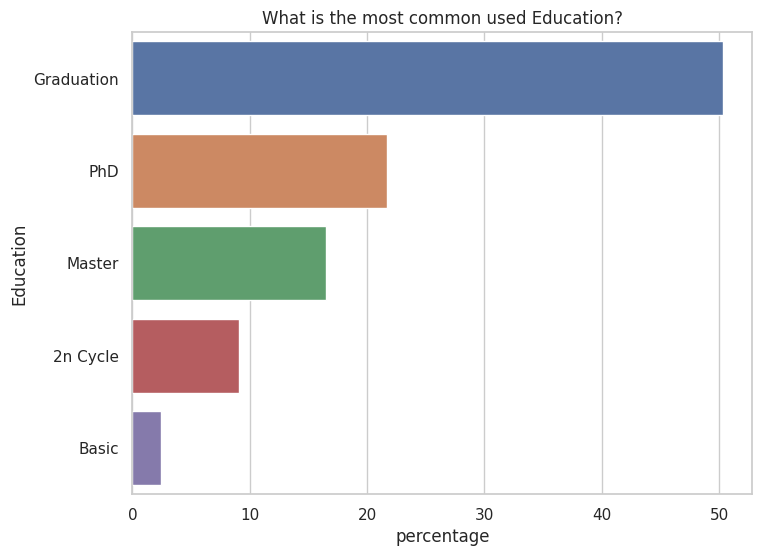

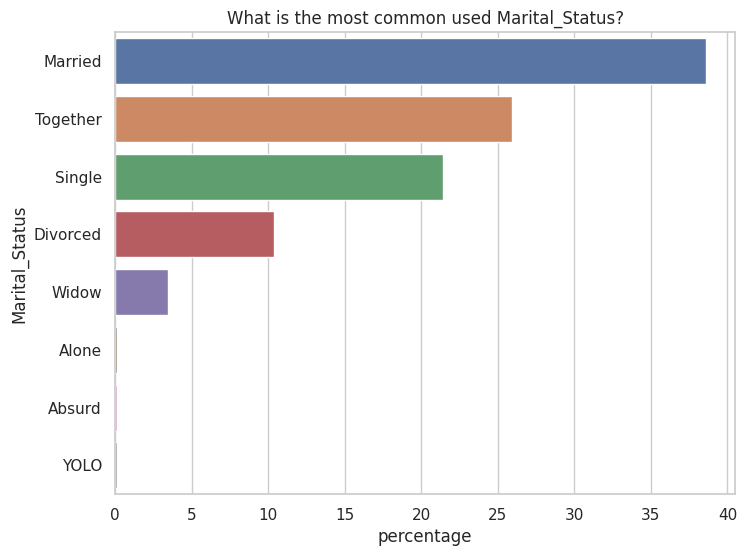

In [20]:
category_cols = df.select_dtypes('object').columns

for col in category_cols:
    plot_data_frequency(df, col, 20, save_plot=True)

For Marital_Status, we have little data for three types of status which are [Alone, Absurd, YOLO]. Regarding the status [Absurd, YOLO] actually do not have a variale meaning related to marital status, we will convert these status to only two types [Partner, Alone], where 'Partner' if the status is either 'married' or 'together', otherwise we will replace it with 'alone' as status.

### Time Series Analysis

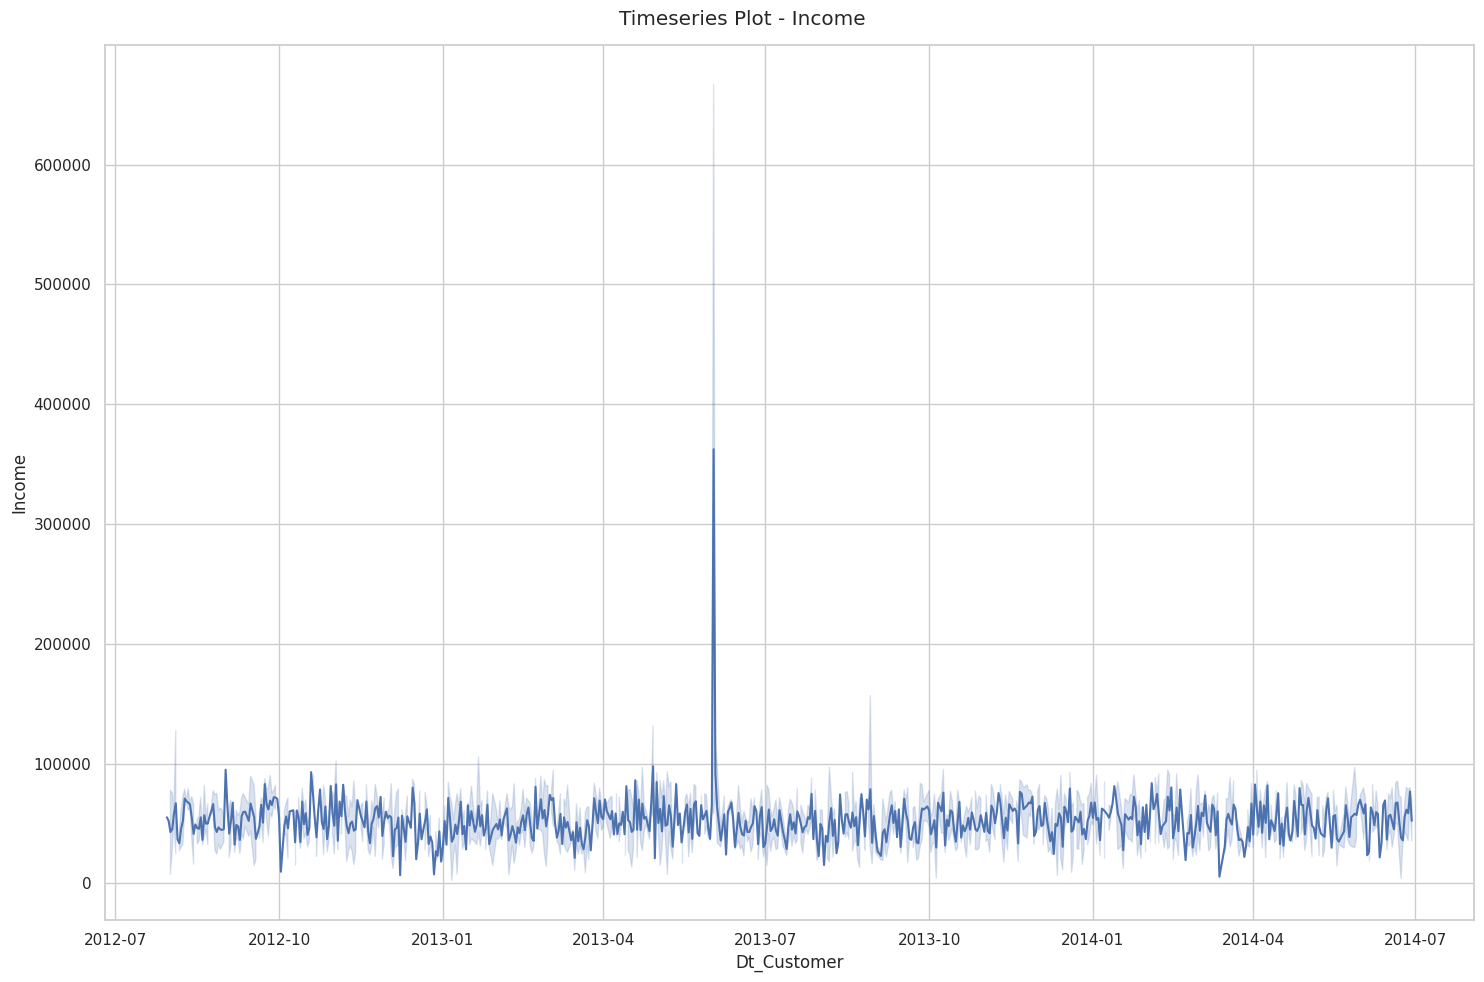

In [21]:
timeseries_col = 'Dt_Customer'
target_col = 'Income'
depended_cols = None
plot_timeseries_trend(df=df,
                      timestamp_col=timeseries_col,
                      target_col=target_col,
                      groupby_lst=depended_cols,
                      fig_title='Timeseries Plot - Income',
                      save=True)

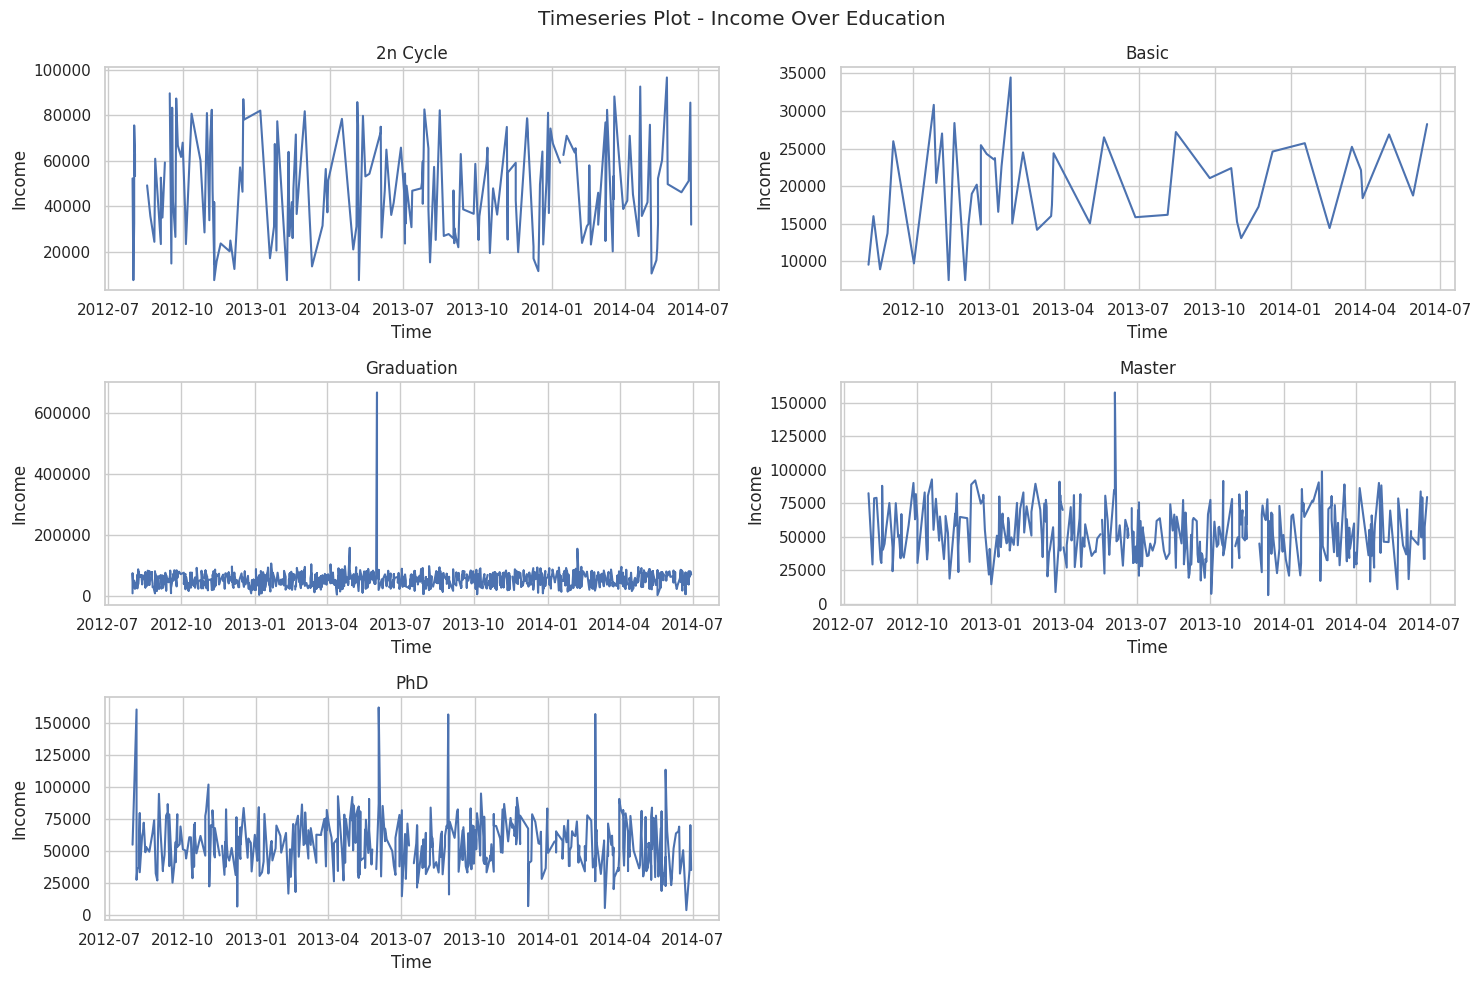

In [22]:
timeseries_col = 'Dt_Customer'
target_col = 'Income'
depended_cols = ['Education']
plot_timeseries_trend(df=df,
                      timestamp_col=timeseries_col,
                      target_col=target_col,
                      groupby_lst=depended_cols,
                      fig_title='Timeseries Plot - Income Over Education',
                      save=True)

Insights:
- For time series visualization according to the value of Income, which is the customer yearly household income, there is no an overall trend, and we need to remove the outliers to have a better view.
- Cutting the data based on the Education, to have better insights over the Income timeseries plot, the most of the education types are noise, and does not give much of trend.
- In overall, there is no trend in the Income of the customers over the years, and we need to remove outliers to have better visual of the seasonality.

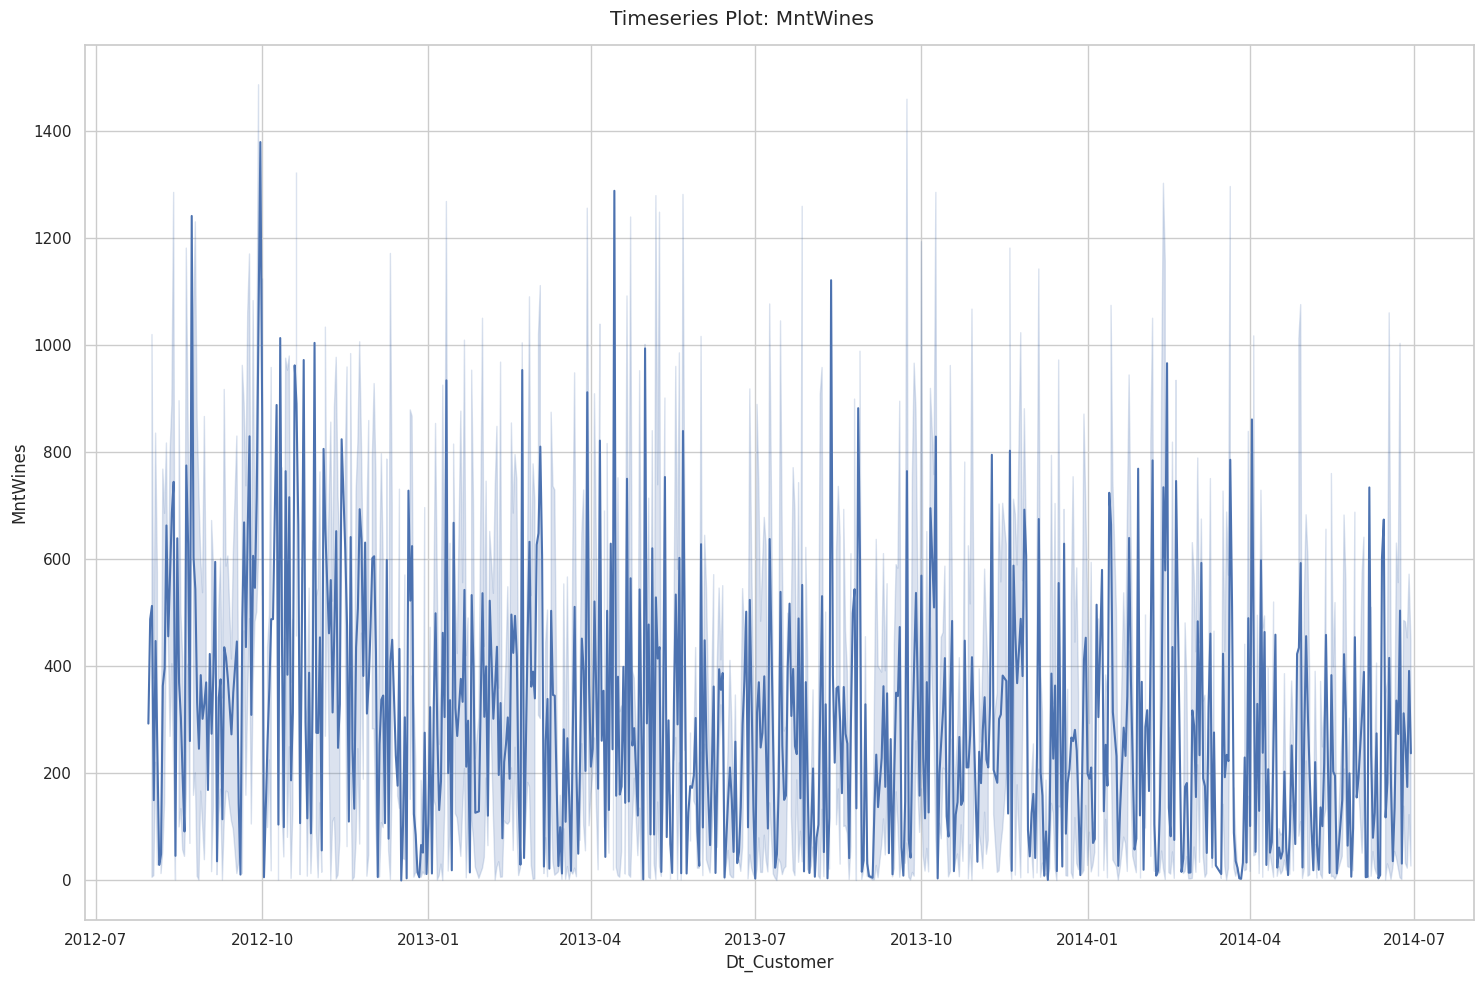

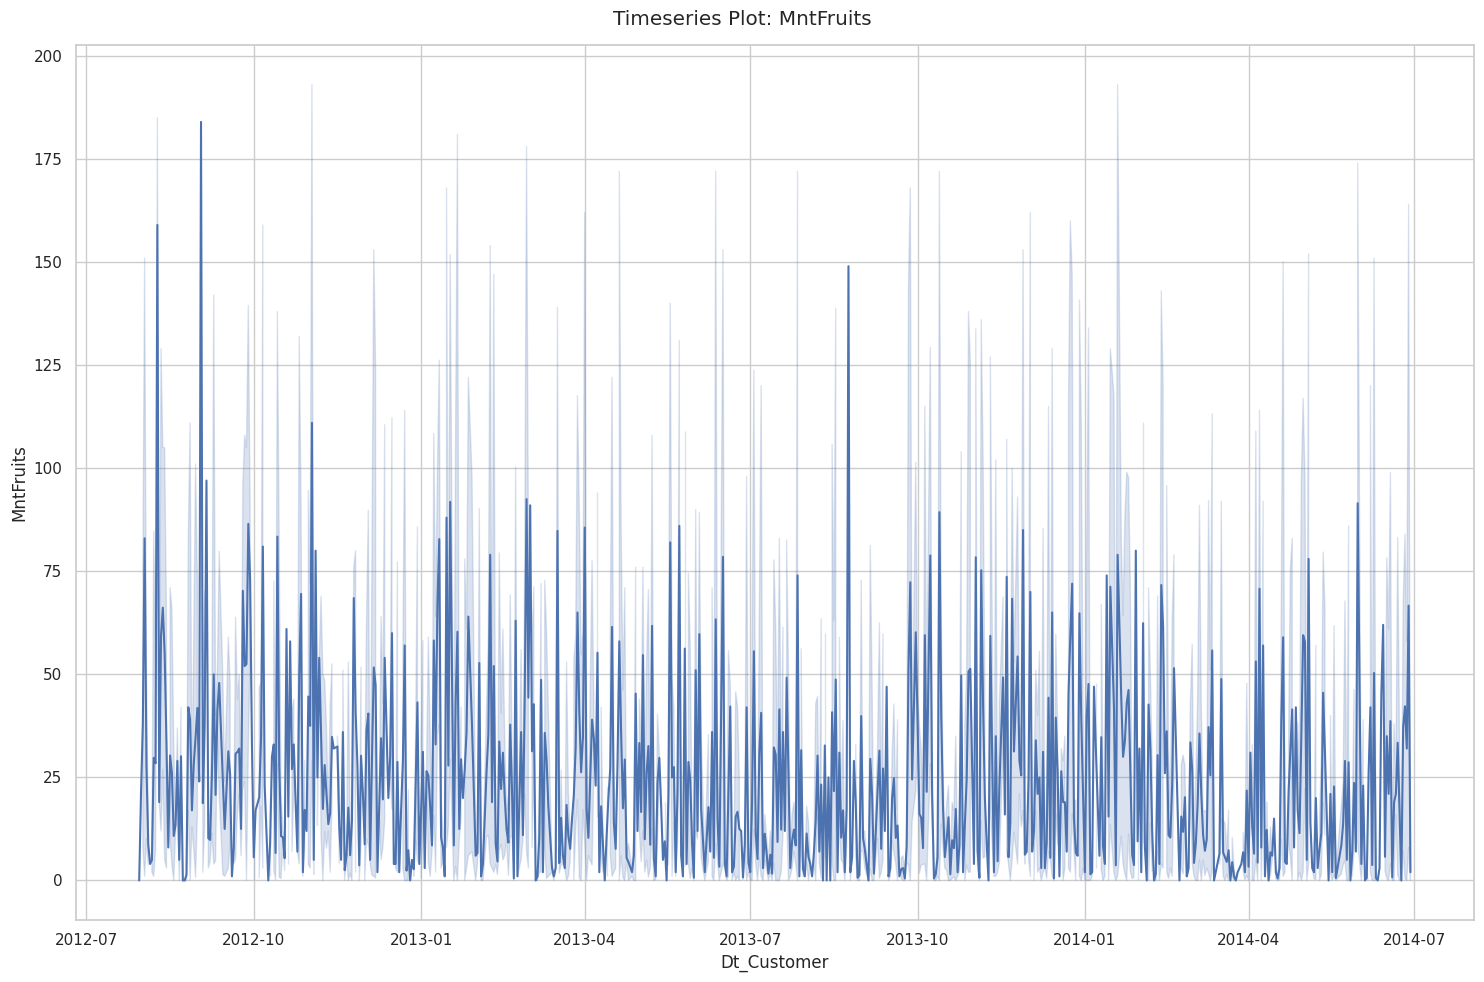

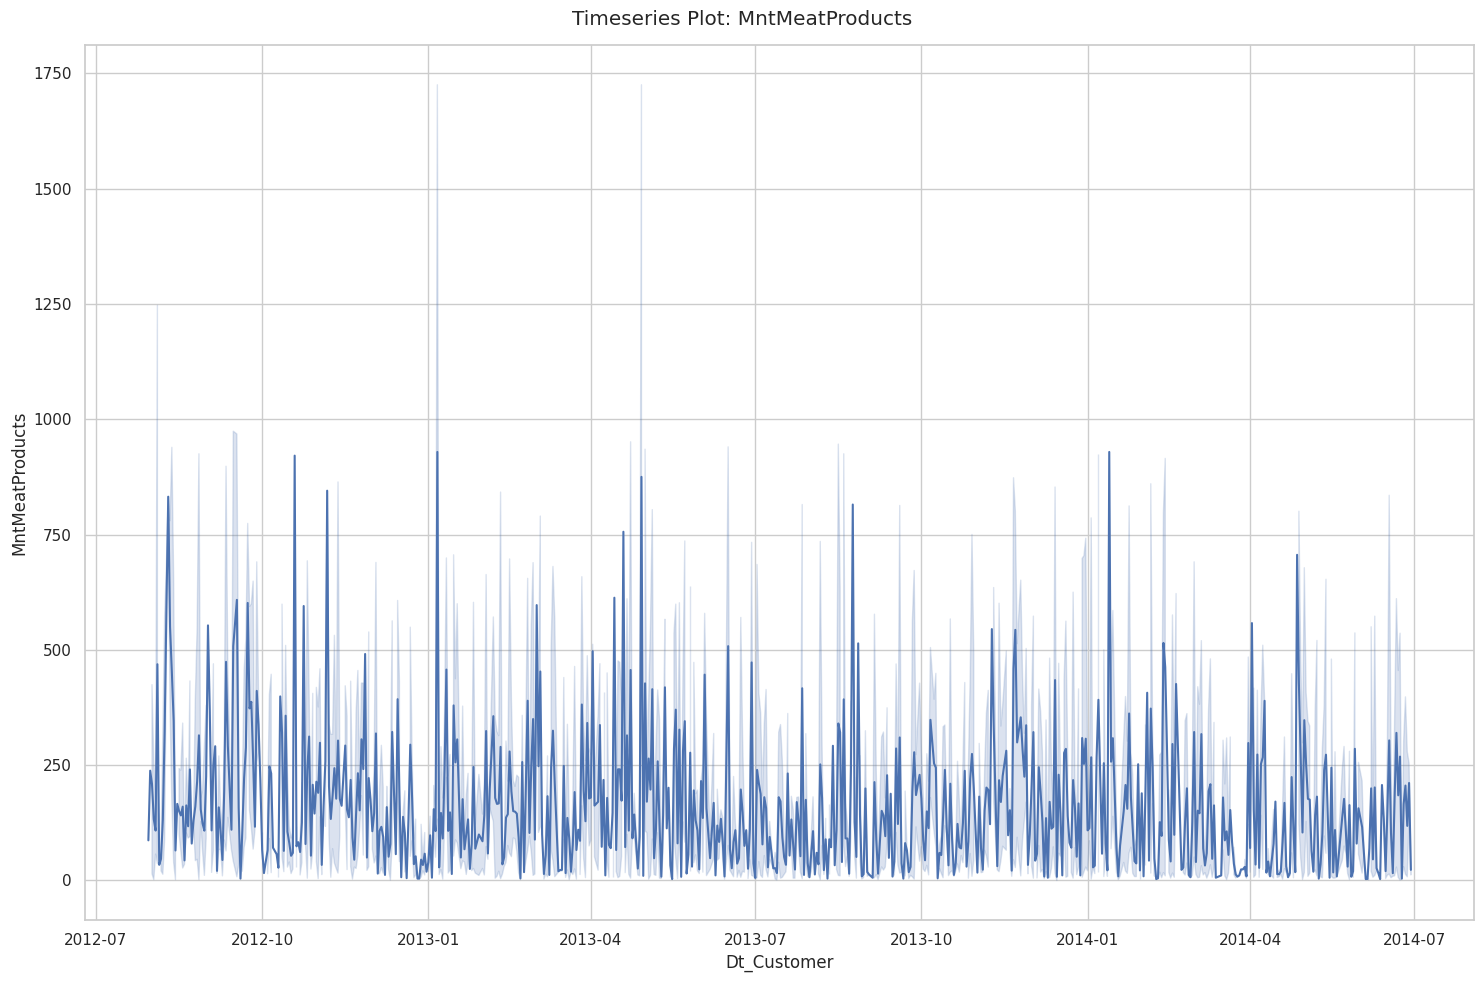

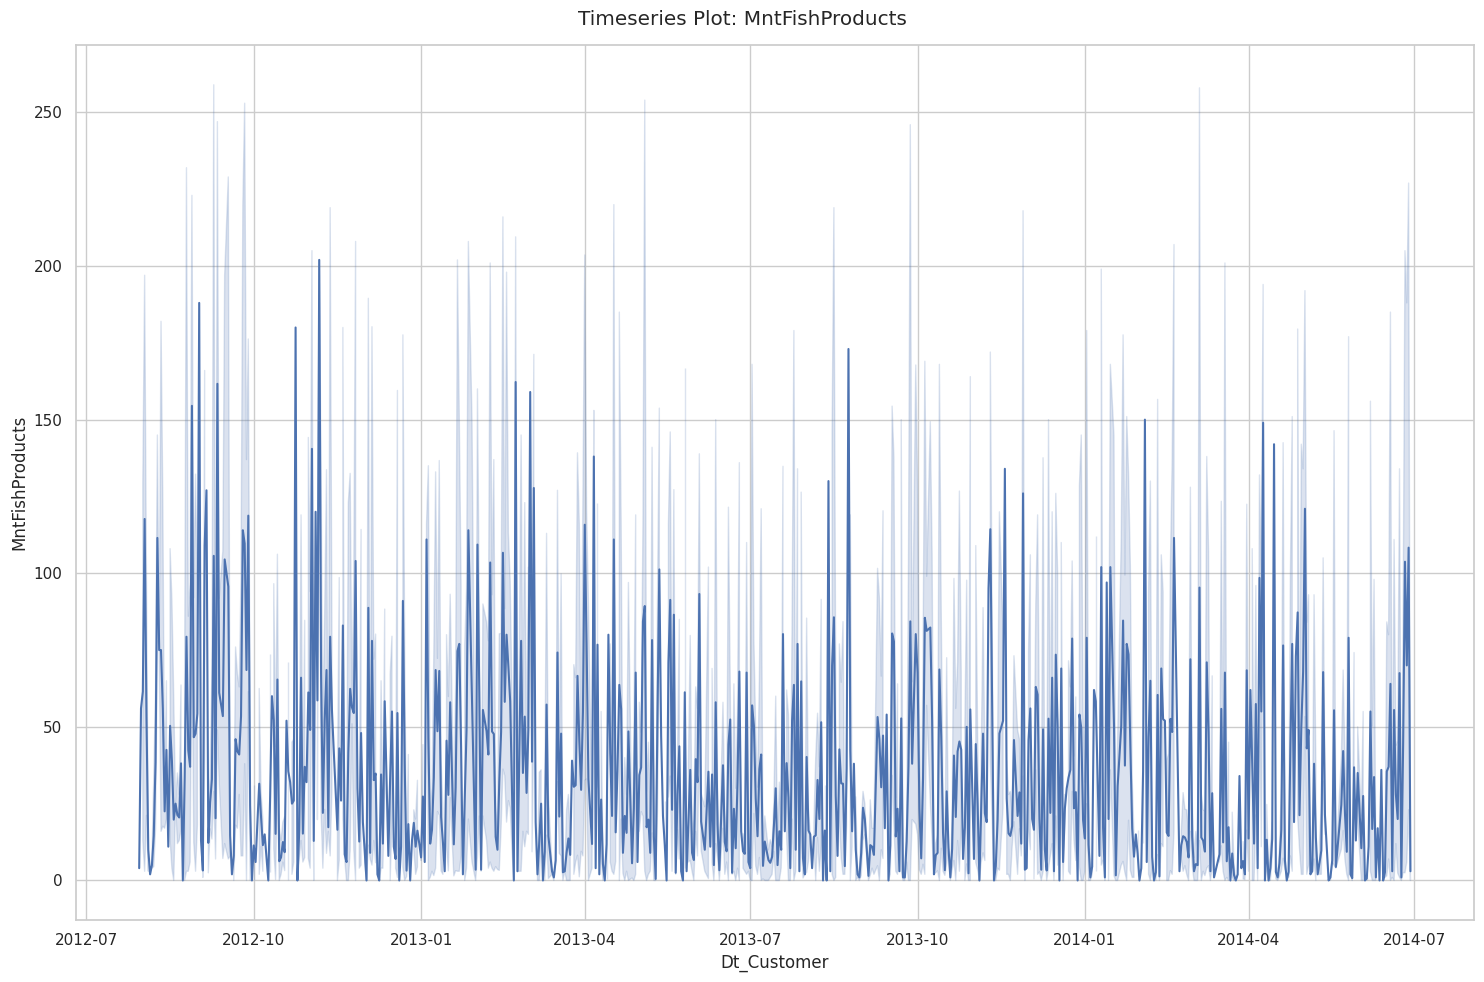

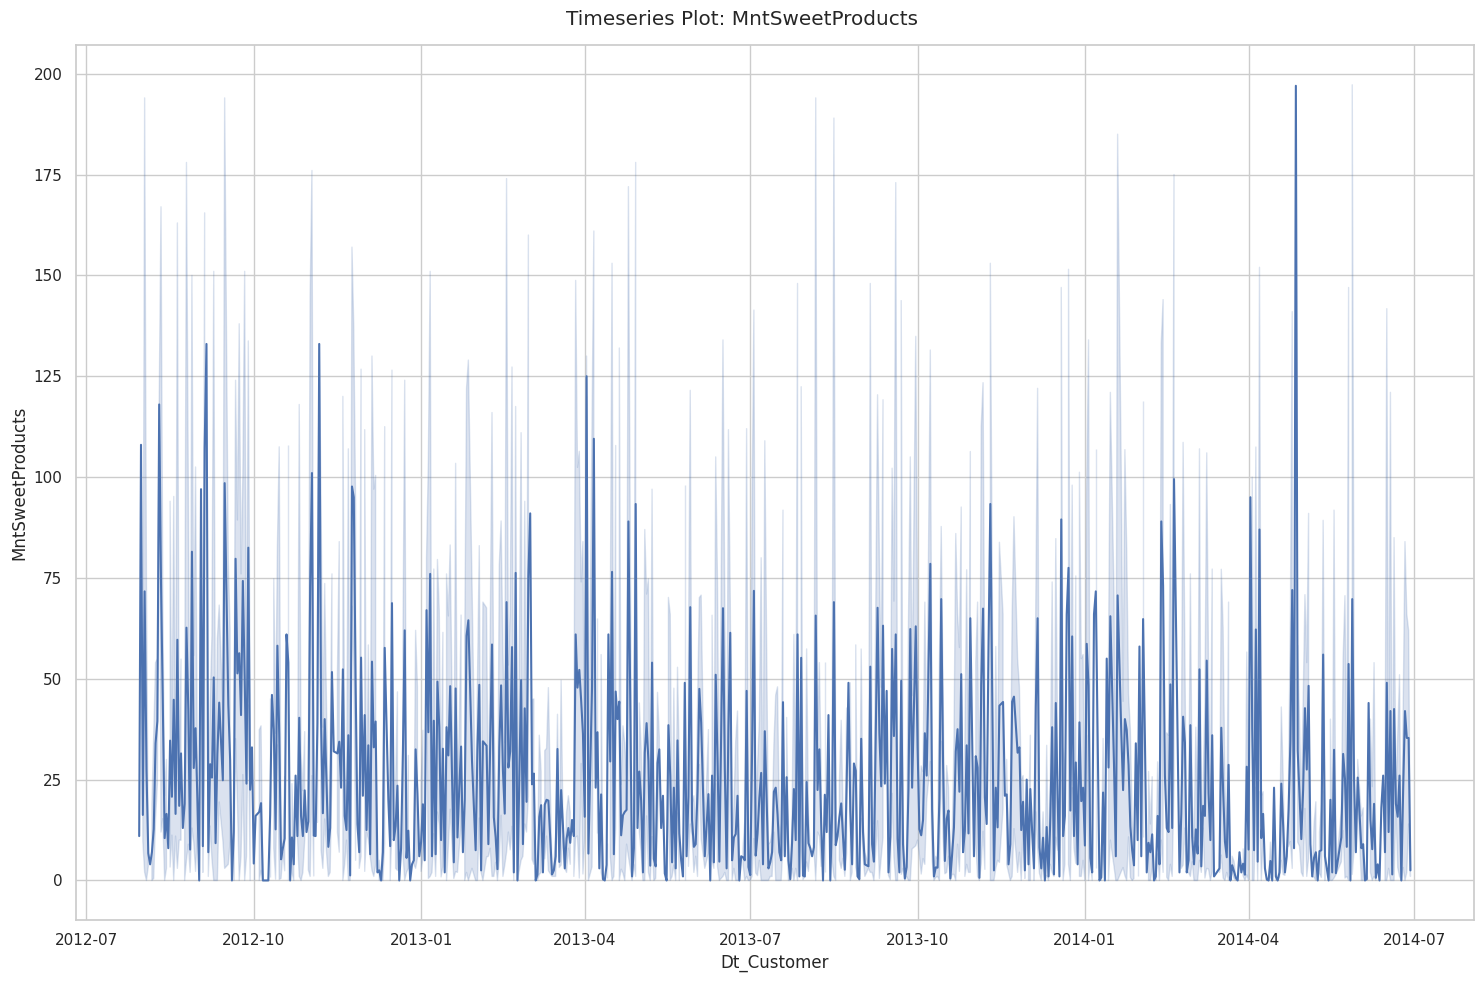

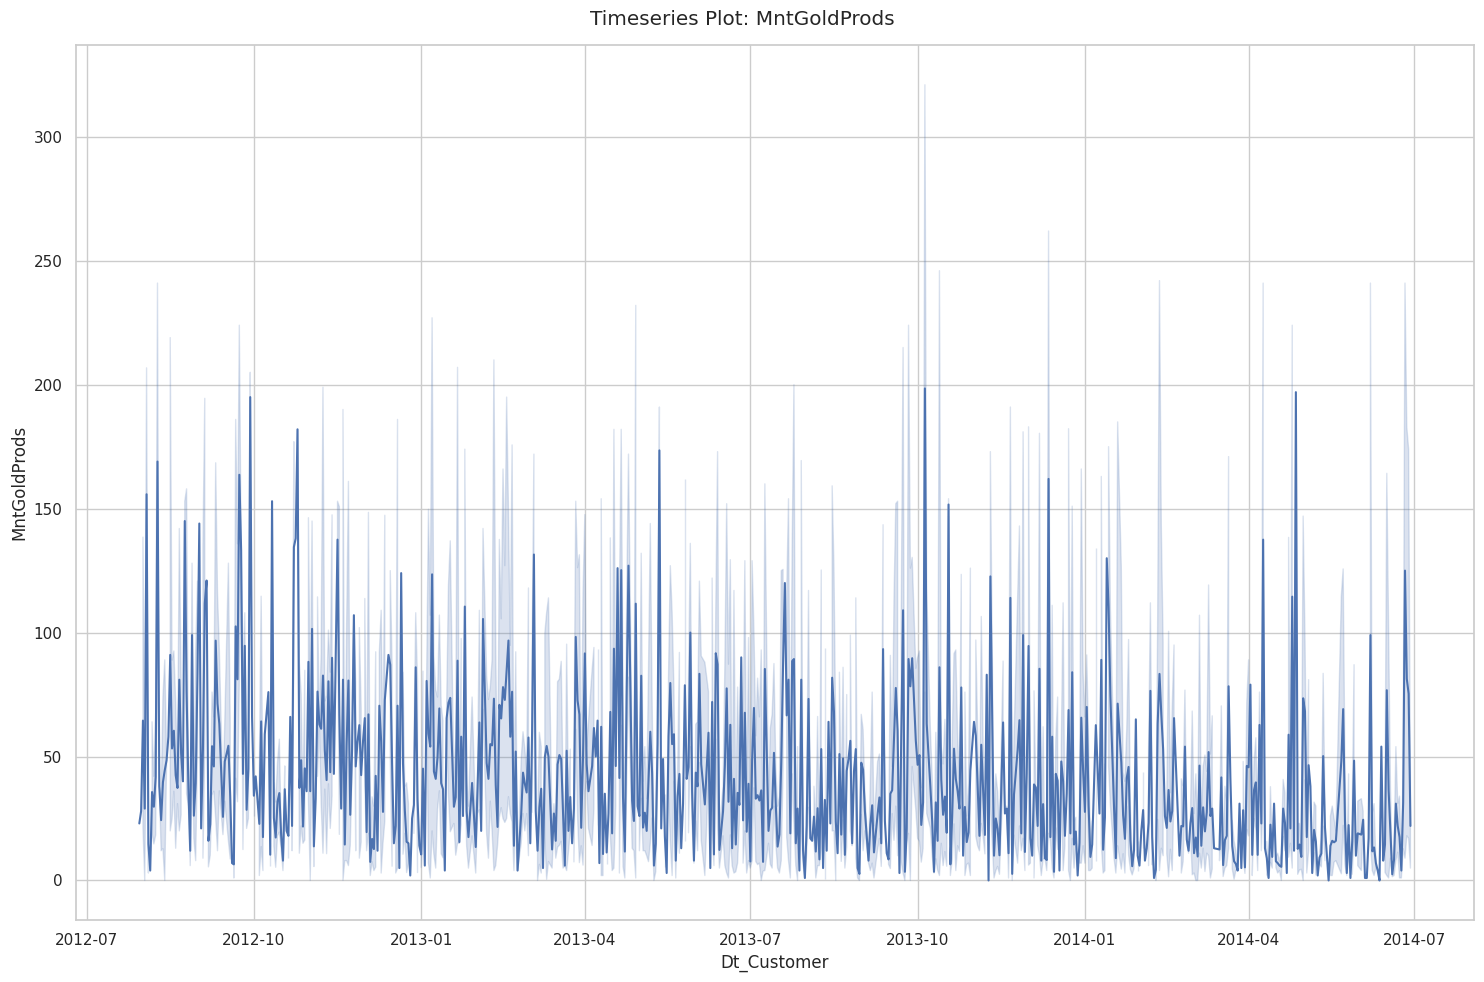

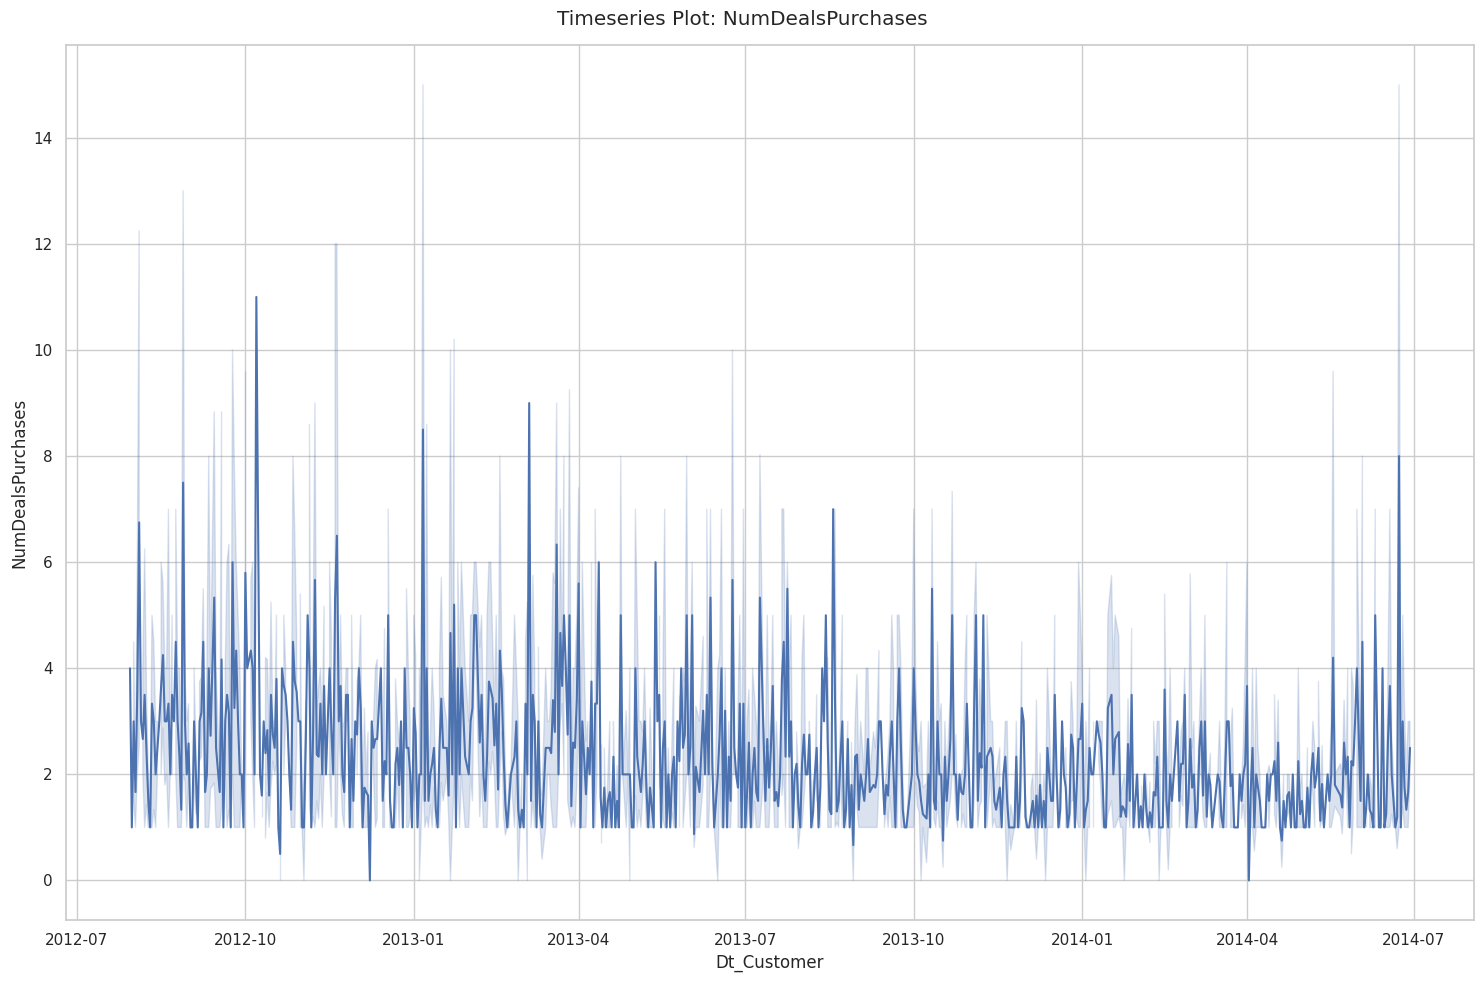

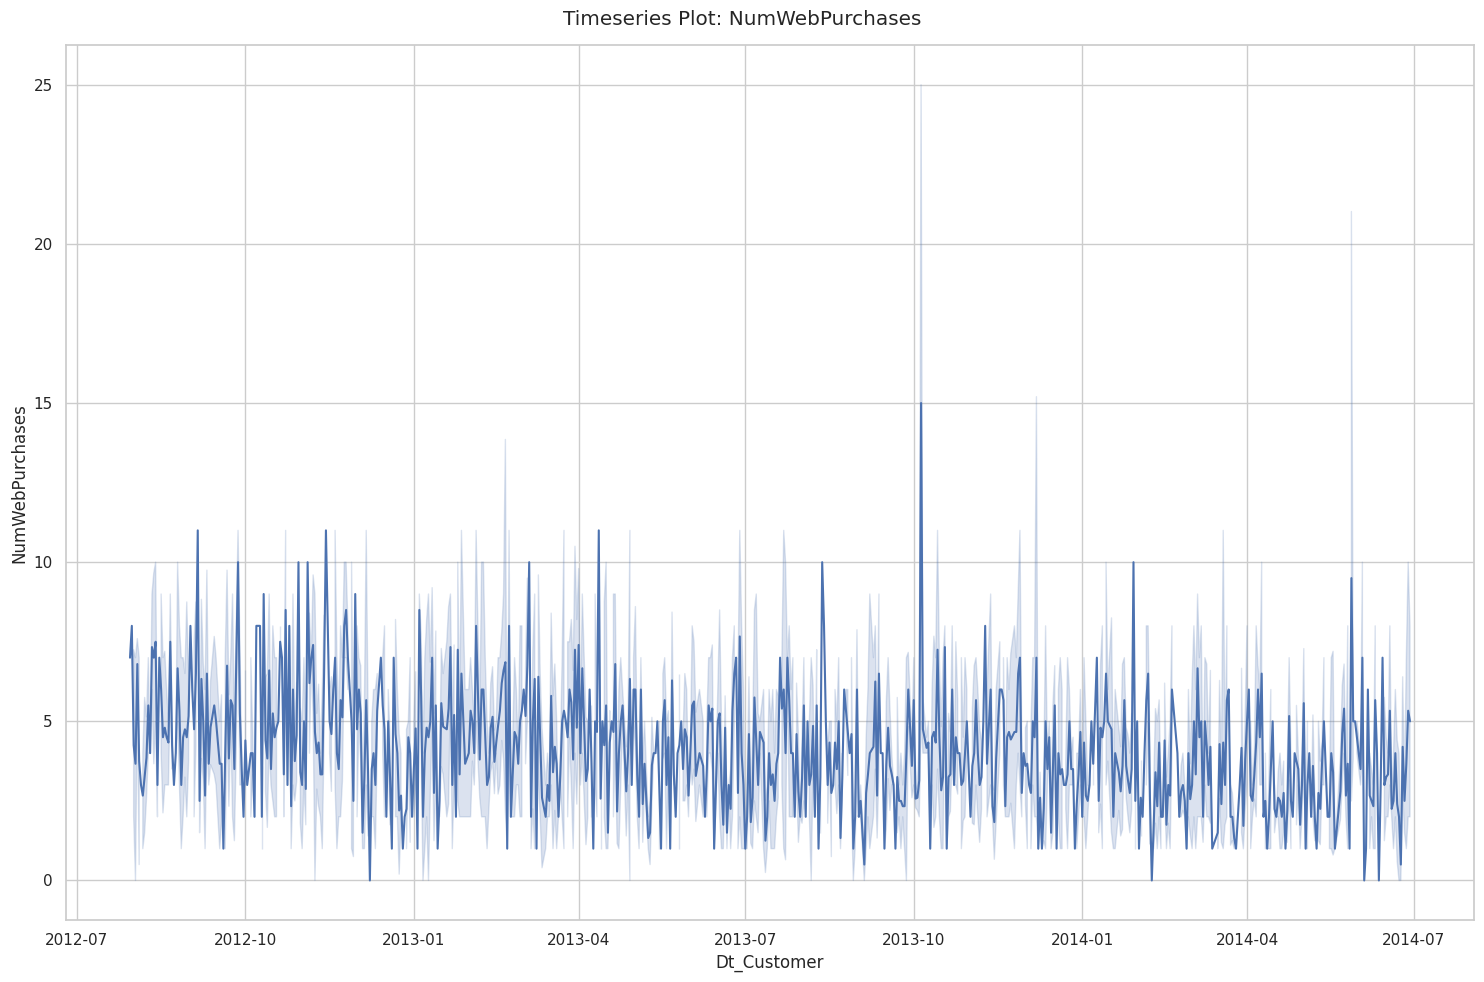

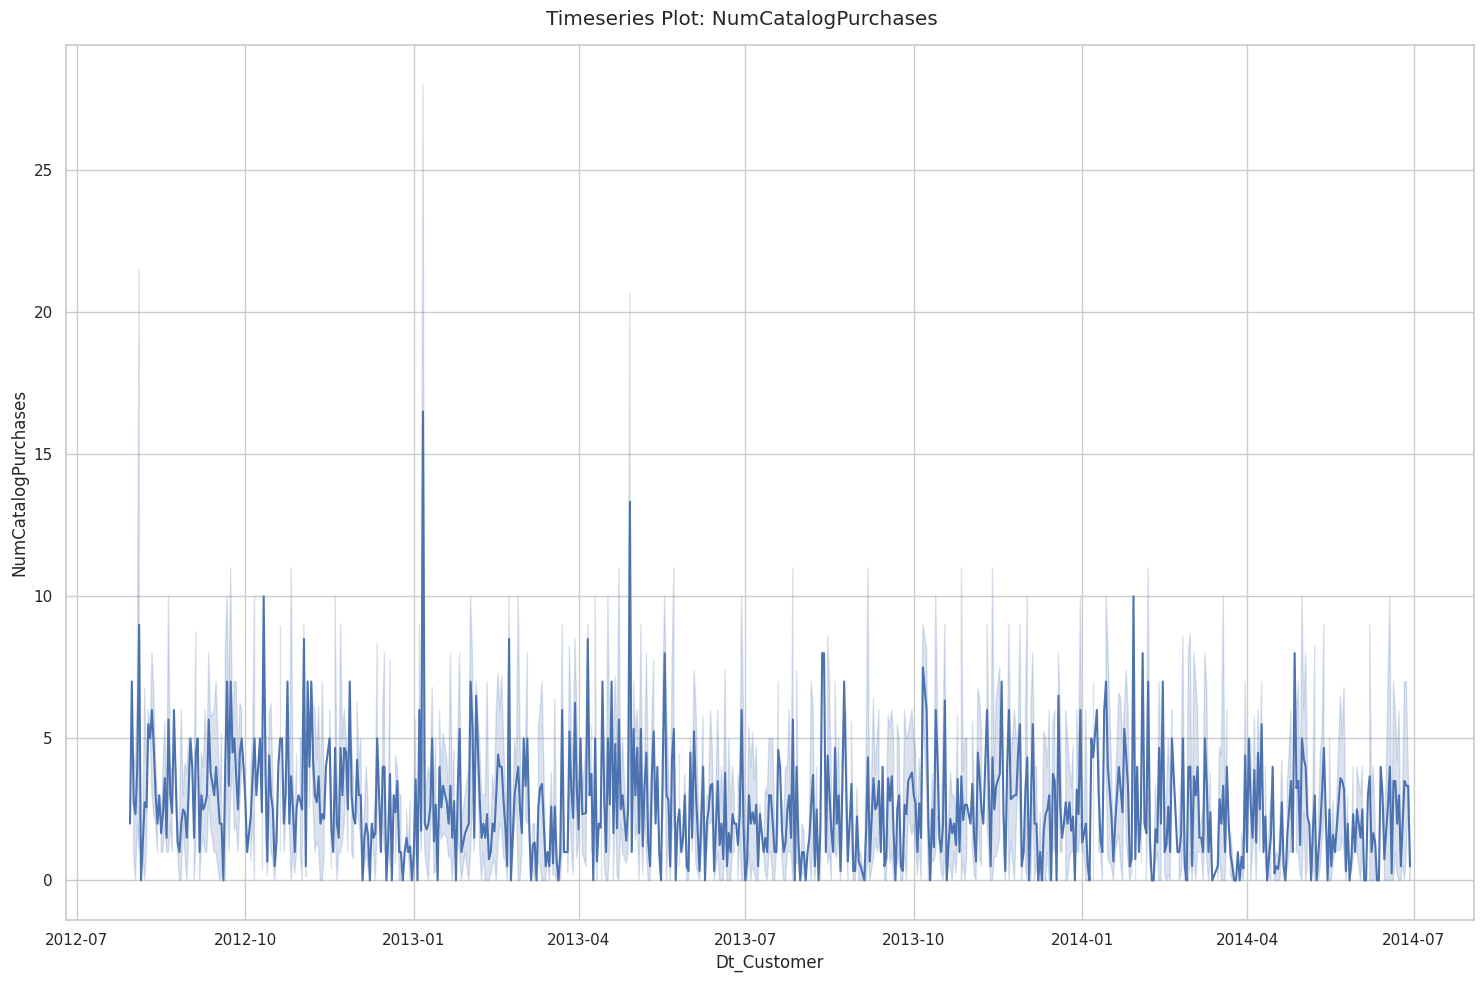

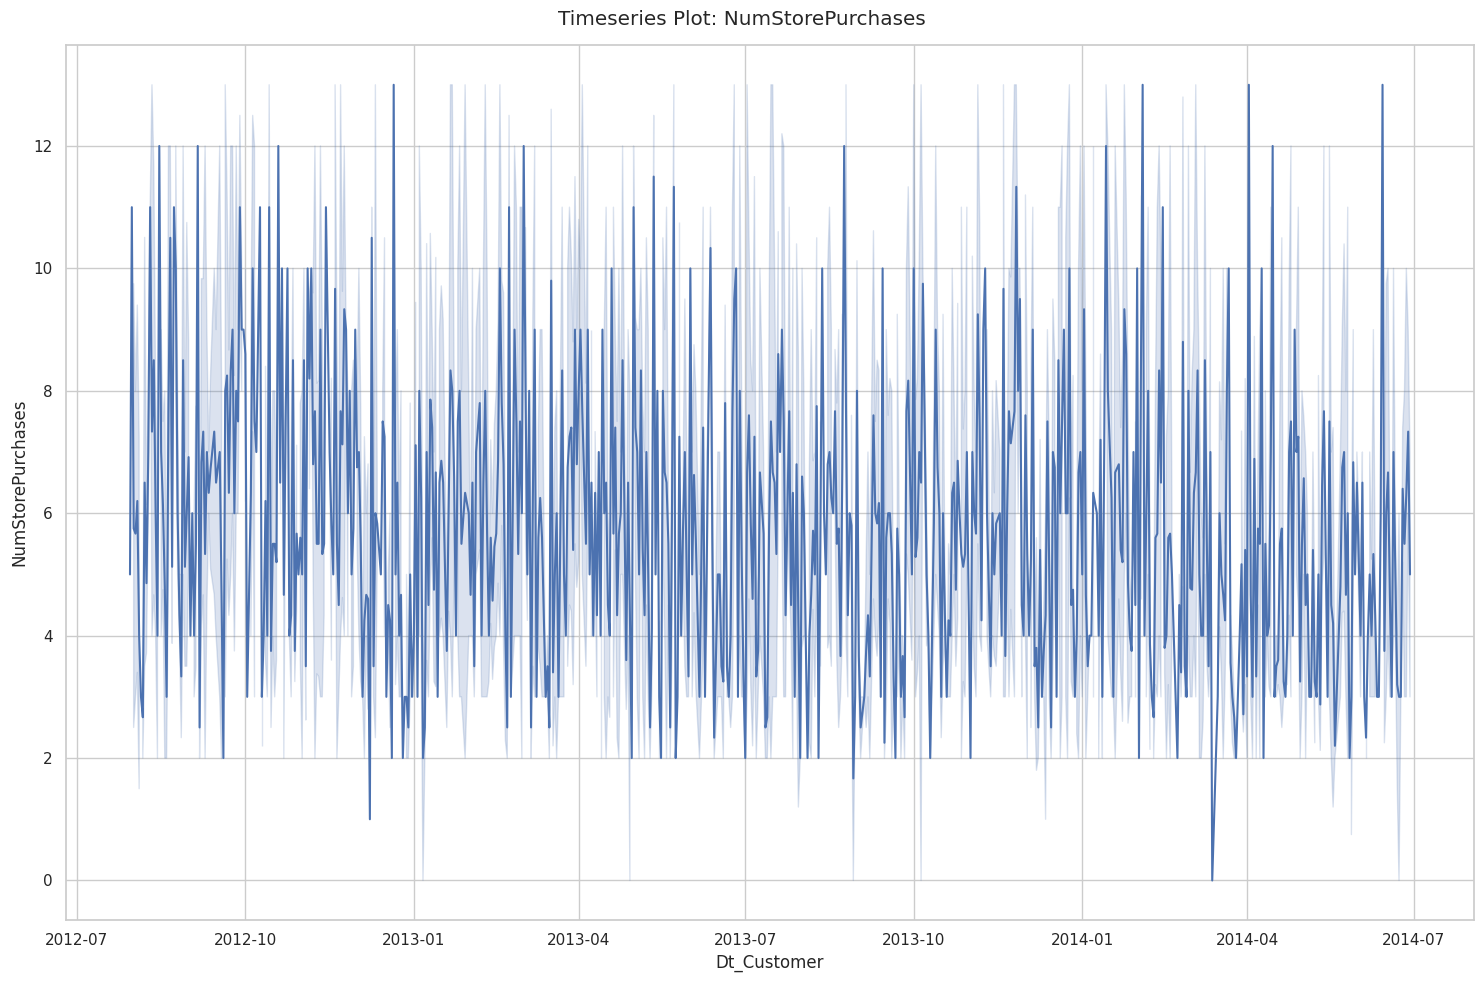

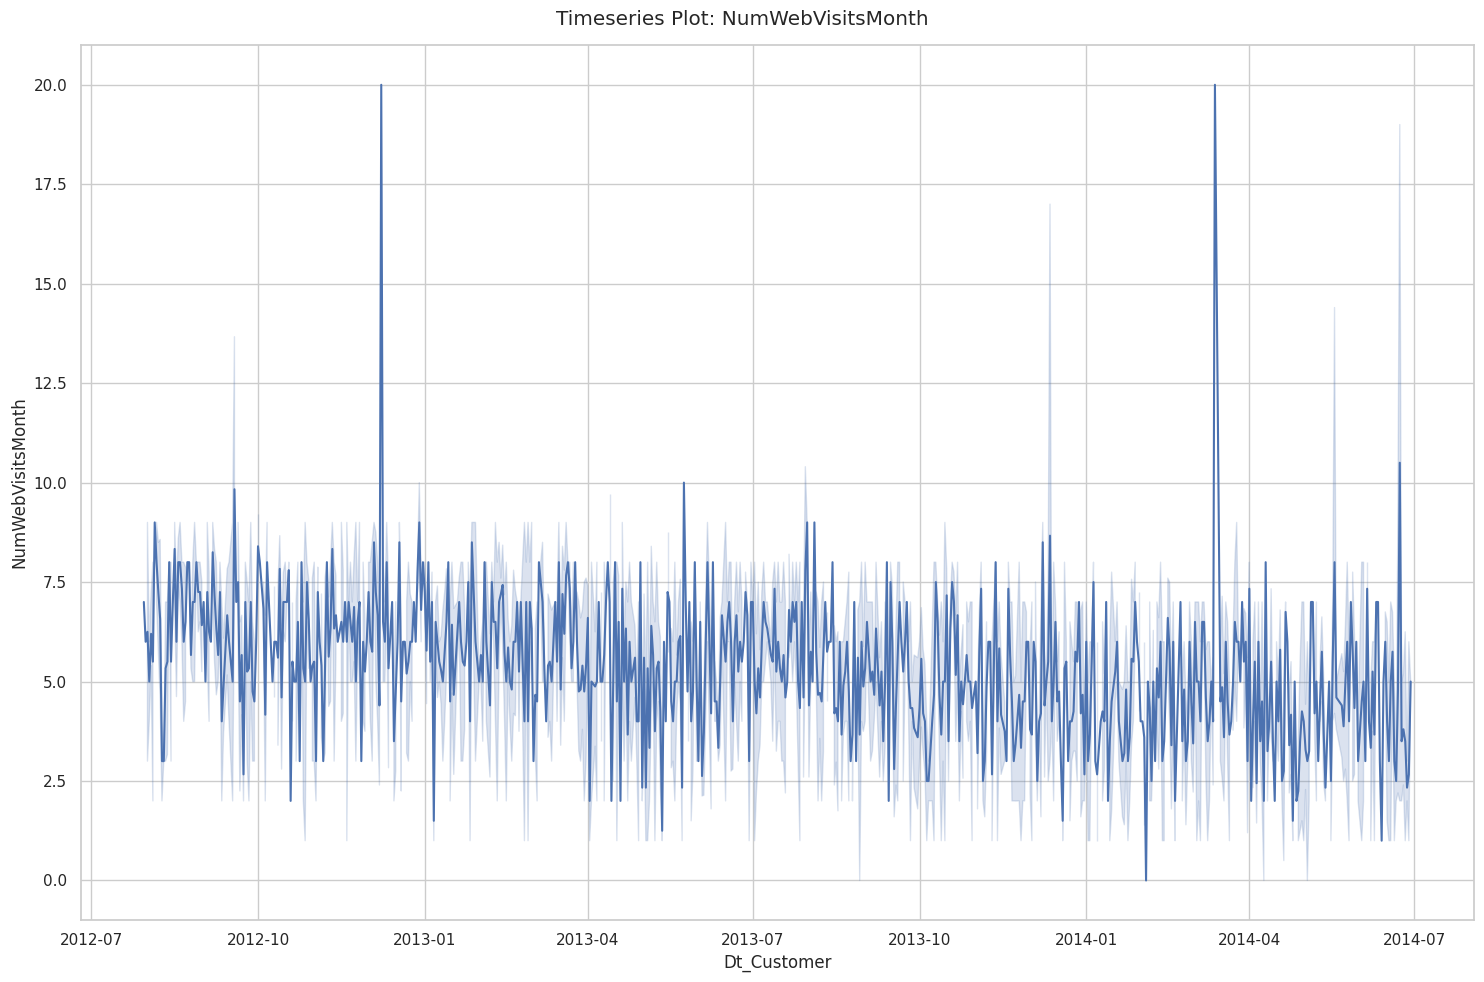

In [23]:
timeseries_col = 'Dt_Customer'
target_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
    'NumStorePurchases', 'NumWebVisitsMonth']
depended_cols = None

for target_col in target_cols:
    plot_timeseries_trend(df=df,
                        timestamp_col=timeseries_col,
                        target_col=target_col,
                        groupby_lst=depended_cols,
                        fig_title=f'Timeseries Plot: {target_col}',
                        save=False)

Insights:
- Some features like [NumWebVisitsMonth, NumWebPurchases] have a trend which indicates that the customers usage of web is decreasing, but we need to clean the data first to remove the noise.